In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import Omniglot
from torch.utils.data import DataLoader
import tempfile

# Omniglot Dataset
- Background: Training, Evaluation: Testing
- There are 50 langauges
- Each language has multiple characters
- There are 964 characters in training set and 659 characters in testing set
- Each character has 20 samples each written by a different person

In [2]:
tmp_dir = tempfile.TemporaryDirectory() # make temp directory for omniglot dataset that can be later cleaned up easily

In [3]:
transform = transforms.Compose([
    transforms.Resize((28, 28)), # from 105 x 105, to reduce model size and computation
    transforms.ToTensor(), # PIL image to tensor shape (1, 28, 28), and pixel values from 0-255 to 0-1
    transforms.Lambda(lambda x: 1.0 - x),  # Invert the colors, white on black, emperically helps training
])

In [4]:
train_dataset = Omniglot(
    root=tmp_dir.name,
    background=True, # background characters only, ie training set
    transform=transform,
    download=True
)

100%|██████████| 9.46M/9.46M [00:00<00:00, 101MB/s]


In [5]:
print(type(train_dataset))
print(f"Total number of images: {len(train_dataset)}")
print(f"Sample item format: {train_dataset[0]}")
print(f"Label of first image: {train_dataset[0][1]}")

<class 'torchvision.datasets.omniglot.Omniglot'>
Total number of images: 19280
Sample item format: (tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.000

In [6]:
print(train_dataset._characters[0:5])

['Mkhedruli_(Georgian)/character10', 'Mkhedruli_(Georgian)/character27', 'Mkhedruli_(Georgian)/character14', 'Mkhedruli_(Georgian)/character08', 'Mkhedruli_(Georgian)/character40']


In [7]:
print(f"Total character classes: {len(train_dataset._characters)}")

Total character classes: 964


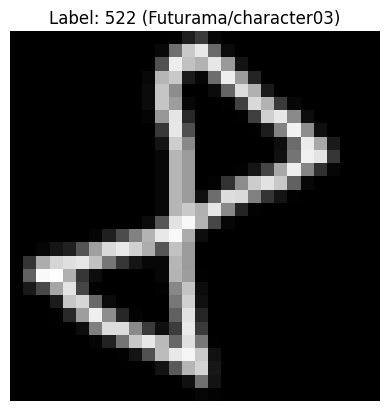

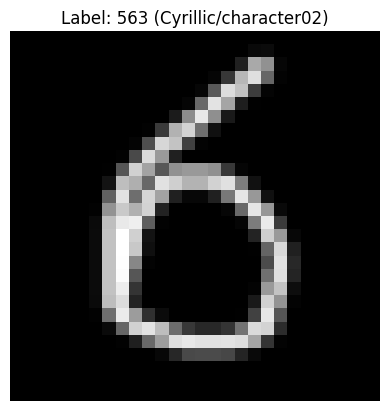

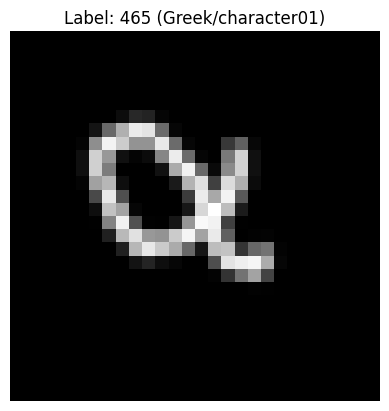

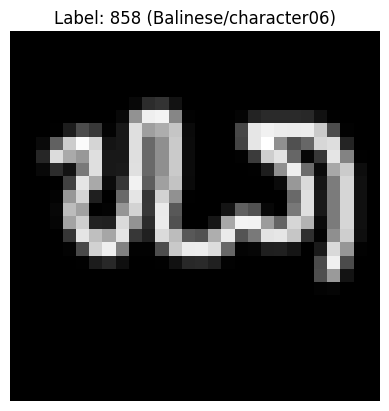

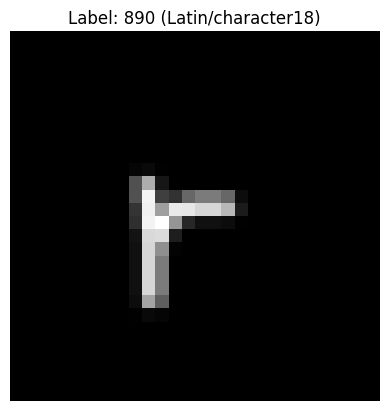

In [8]:
# visualize the samples
import matplotlib.pyplot as plt

def show_image(img_tensor, label=None):
    plt.imshow(img_tensor.squeeze(), cmap='gray') # from (1, 28, 28) to (28, 28), [h,w] for grascale, and [h,w,3] for RGB, [1,h,w] not valid
    if label is not None:
        plt.title(f"Label: {label} ({train_dataset._characters[label]})")
    plt.axis('off')
    plt.show()

# Display 5 random samples
import random
for _ in range(5):
    idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[idx]
    show_image(img, label)

In [9]:
from collections import Counter

label_counts = Counter(label for _, label in train_dataset)
print(f"Number of classes: {len(label_counts)}")
print(f"Samples per class (should be 20): {label_counts.most_common(5)}")


Number of classes: 964
Samples per class (should be 20): [(0, 20), (1, 20), (2, 20), (3, 20), (4, 20)]


# DataLoader
- For Matching Networks/Few-shot learning each training step is a mini-task/episode containing
    - a support set
    - a query set
    - all from a random subset of N classes
    - Need to build a custom episdoe sampler then wrap with Dataloader

Few Shot Episode:
- `N` -> N way, number of classes, N <= 964, but ofcourse make much smaller
- `K` -> K shot, number of samples per class, K <= 20here but make much smaller, 1 shot, 5 shot etc.
- `Q` -> Q query, number of examples per class

In [11]:
from collections import defaultdict

train_class_to_indices = defaultdict(list)
for i, (_, label) in enumerate(train_dataset):
    train_class_to_indices[label].append(i)

In [12]:
print(type(train_class_to_indices)) # defaultdict
print(len(train_class_to_indices)) # 964

<class 'collections.defaultdict'>
964


In [13]:
train_class_to_indices[0] # first 20 indices happen to correspond to class 0

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [14]:
train_class_to_indices[963] # last 20 indices happen to correspond to class 963

[19260,
 19261,
 19262,
 19263,
 19264,
 19265,
 19266,
 19267,
 19268,
 19269,
 19270,
 19271,
 19272,
 19273,
 19274,
 19275,
 19276,
 19277,
 19278,
 19279]

In [15]:
# idx_to_char_name = {i: name for i, name in enumerate(dataset._characters)}
train_idx_to_char_name = {
    i: tuple(name.split('/'))  # split 'Alphabet/characterXX' into (Alphabet, character), hmm maybe shouldn't have done it
    for i, name in enumerate(train_dataset._characters)
}


In [16]:
print(train_idx_to_char_name[0])
print(train_idx_to_char_name[963]) # confusion with this ones type
print(type(train_idx_to_char_name[963])) # str

('Mkhedruli_(Georgian)', 'character10')
('Alphabet_of_the_Magi', 'character15')
<class 'tuple'>


In [17]:
# inspect
print(type(train_dataset._characters[0]))
print(train_dataset._characters[0]) # some older version of omniglot will have ("Gujarati", "character42") etc


<class 'str'>
Mkhedruli_(Georgian)/character10


In [18]:
class FewShotEpisodeDataset(Dataset):
    """
    Params:
        - dataset: Omniglot dataset
        - classes_to_indices: dictionary, which maps class to all the indices in the dataset that correspond to that class
        - num_ways: number of classes to sample for each episode
        - num_shots: number of support examples per class
        - num_queries: number of query examples per class
        - num_episodes: number of episodes to sample

    __get__item method: returns a random episode (here it is not hte ith index of the dataset, but a random episode)

    """
    def __init__(self, dataset, class_to_indices, idx_to_char_name, num_ways=5, num_shots=1, num_queries=1, num_episodes=1000):
        self.dataset = dataset
        self.class_to_indices = class_to_indices
        self.classes = list(class_to_indices.keys())
        self.num_ways = num_ways
        self.num_shots = num_shots
        self.num_queries = num_queries
        self.num_episodes = num_episodes
        self.idx_to_char_name = idx_to_char_name

    def __len__(self):
        # implentation of __len__ method of Dataset pytorch class
        return self.num_episodes

    def __getitem__(self, _):
        # implentation of __getitem__ method of Dataset pytorch class
        support_images, support_labels = [], []
        query_images, query_labels = [], []

        chosen_classes = random.sample(self.classes, self.num_ways) # from all the classes available randomly sample num_ways classes
        label_map = {cls: i for i, cls in enumerate(chosen_classes)} # map the class to a new label, eg. classes 4, 93, and 12 become 0, 1, and 2

        for cls in chosen_classes:
            indices = random.sample(self.class_to_indices[cls], self.num_shots + self.num_queries) # from all the samples you have of that class, randomly pick some to be support and some to be query, so 5shot 1 query, means 6 samples from 20 available in omniglot
            support_idxs = indices[:self.num_shots] # first num_shots samples are support
            query_idxs = indices[self.num_shots:]

            support_images += [self.dataset[i][0] for i in support_idxs]
            support_labels += [label_map[cls]] * self.num_shots
            query_images += [self.dataset[i][0] for i in query_idxs]
            query_labels += [label_map[cls]] * self.num_queries

        return {
            "support_images": torch.stack(support_images),
            "support_labels": torch.tensor(support_labels),
            "query_images": torch.stack(query_images),
            "query_labels": torch.tensor(query_labels),
            "class_names": [self.idx_to_char_name[c] for c in chosen_classes]
        }

----------------Printing episode details----------------
Support Image shape: torch.Size([5, 1, 28, 28])
Support Label shape : torch.Size([5])
Class names: [[('Cyrillic',), ('character23',)], [('Sanskrit',), ('character28',)], [('Mkhedruli_(Georgian)',), ('character25',)], [('Latin',), ('character24',)], [('Braille',), ('character10',)]]
-----------------------------------------------------


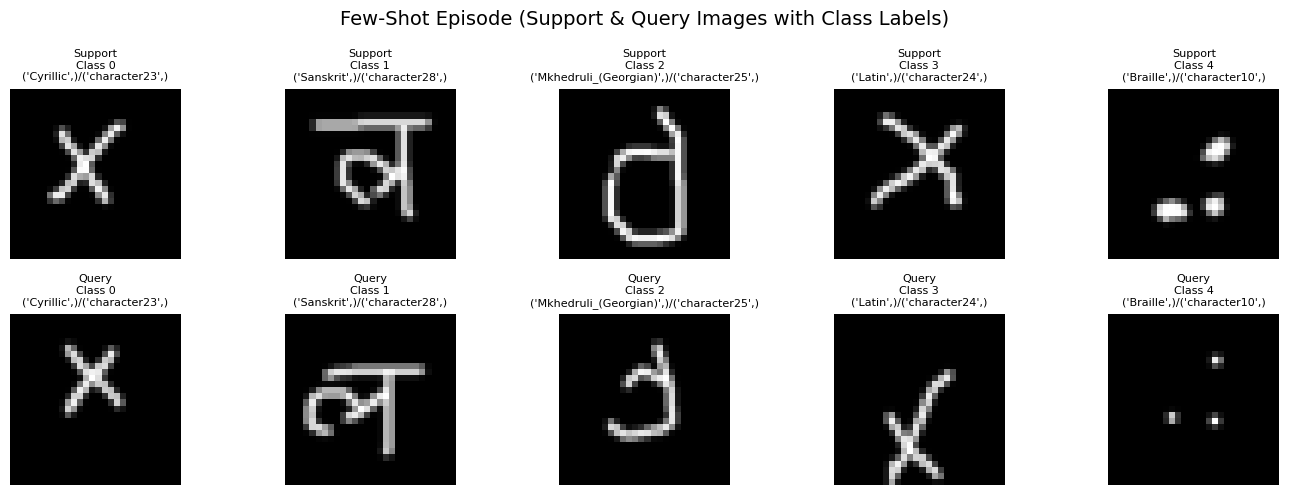

In [19]:
episode_dataset = FewShotEpisodeDataset(train_dataset, train_class_to_indices, train_idx_to_char_name, num_ways=5, num_shots=1, num_queries=1) # 5-way 1-shot 1-query
# batch size: number of episodes per gradient step/batch, we compute loss over all queries in a batch in one iteration, and backpropogate losses
episode_loader = DataLoader(episode_dataset, batch_size=1, shuffle=True)

def visualize_episode(episode):
    """
    visualize a few shot epidsode and look at the support and query images
    """
    print("----------------Printing episode details----------------")
    print(f"Support Image shape: {episode['support_images'][0].shape}")
    print(f"Support Label shape : {episode['support_labels'][0].shape}")
    print(f"Class names: {episode['class_names']}")
    print("-----------------------------------------------------")
    support_imgs = episode['support_images'][0] # doesn't matter what the index is? since getitem returns some random episode
    support_labels = episode['support_labels'][0]
    query_imgs = episode['query_images'][0]
    query_labels = episode['query_labels'][0]
    class_names = episode['class_names']

    num_classes = len(class_names)
    fig, axes = plt.subplots(2, num_classes, figsize=(14, 5))
    fig.suptitle("Few-Shot Episode (Support & Query Images with Class Labels)", fontsize=14)

    # print(type(class_names[0]))  #  <class 'tuple'>
    # print(class_names[0])        #  ('Mkhedruli_(Georgian)/character11',)
    # print(class_names[0][0].split('/')) # ['Armenian', 'character38']

    for i in range(num_classes):
        # --- Support ---
        support_class_idx = support_labels[i].item()
        # l = class_names[support_class_idx][0].split('/')
        # alphabet= l[0]
        # character = l[1]
        alphabet, character = class_names[support_class_idx]
        axes[0][i].imshow(support_imgs[i].squeeze(), cmap='gray')
        axes[0][i].set_title(f"Support\nClass {support_class_idx}\n{alphabet}/{character}", fontsize=8)
        axes[0][i].axis('off')

        # --- Query ---
        query_class_idx = query_labels[i].item()
        alphabet, character = class_names[query_class_idx]
        axes[1][i].imshow(query_imgs[i].squeeze(), cmap='gray')
        axes[1][i].set_title(f"Query\nClass {query_class_idx}\n{alphabet}/{character}", fontsize=8)
        axes[1][i].axis('off')

    plt.tight_layout()
    plt.show()


# Visualize a few episodes
episode = next(iter(episode_loader))
visualize_episode(episode)


# Model

In [20]:
def ConvLayer(in_channels, out_channels):
    cnnSeq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels), # normalise the output of the conv layer
        nn.MaxPool2d(kernel_size=2),
        # nn.Dropout(prob)
    )
    return cnnSeq

# Embedding network: Section 2.1 - CNN used for f(x) and g(x)
# "parameterised variously as deep convolutional networks..."
# we apply the same cnn to both the support and query images, 5 at once parallely in batch processing
# shared feature extractor like in hte paper
# because we want to map to same embedding space
class ConvEmbeddingNet(nn.Module):
    def __init__(self, output_size=64):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvLayer(1, 64),  # 28x28 -> 14x14 (maxpool), 1 gray scale image in channel, 64 out channels
            ConvLayer(64, 64),  # 14x14 -> 7x7
            ConvLayer(64,64),  # 7x7 -> 3x3
            nn.Flatten(),  # 64 * 3 * 3 = 576 dims
            nn.Linear(576, output_size)  # final embedding size
        )

    def forward(self, x):
        return self.encoder(x)


# Full Context Embedding for Support Set (BiLSTM)
# Section 2.1.2: "... we use a bidirectional LSTM to encode xi
# use bidirectional lstm to get full context of the support set
# so g'(x1) to g'(xN*K) from CNN(support embeddings)
# output: context enhances embeddings for each support image
class SupportSetEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.lstm = nn.LSTM(embed_dim, embed_dim, batch_first=True, bidirectional=True)
        self.projection = nn.Linear(embed_dim * 2, embed_dim)  # reduce back to original dim

    def forward(self, support_embeddings):
        # support_embeddings: (N*K, D)
        # Add sequence dimension: (1, N*K, D)
        seq = support_embeddings.unsqueeze(0)
        contextual, _ = self.lstm(seq)  # output: (1, N*K, 2*D)
        contextual = contextual.squeeze(0)  # remove sequence dim -> (N*K, 2*D)
        return self.projection(contextual)  # project back to D

# Attention LSTM for Query Embedding (Section 2.1.2)
# "an LSTM with read-attention over the whole set S"
# full context embedding of hte query (Attention LSTM)
# query_embedding = LSTM(f′(x̂), attention_over_S)
# query_embeddings = [f(x̂₁|S), f(x̂₂|S), ..., f(x̂_Q|S)]  # shape: [N×Q, D]

class AttentionQueryEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.lstm_cell = nn.LSTMCell(embed_dim * 2, embed_dim) # concatenate query embedding and read (attention weighted sum over support set)
        self.attention = nn.Linear(embed_dim, embed_dim)

    def forward(self, query_embedding, support_embeddings, steps=1):
        # query_embedding: (D,), support_embeddings: (N*K, D)
        h = torch.zeros_like(query_embedding) # long term
        c = torch.zeros_like(query_embedding) # short term

        for _ in range(steps):
            # Compute attention weights
            attn_query = self.attention(h)  # (D,) # pass in the hidden state
            similarities = torch.matmul(support_embeddings, attn_query)  # (N*K,)
            weights = F.softmax(similarities, dim=0)

            # Weighted read from support set
            read = torch.sum(weights.unsqueeze(1) * support_embeddings, dim=0)  # (D,)

            # LSTM update
            h, c = self.lstm_cell(torch.cat([query_embedding, read], dim=-1), (h, c))

        return h  # final attended query representation


# Matching Network using attention and context-aware embeddings
# Equation (1): y_hat = sum_i a(x̂, x_i) * y_i
class MatchingNetworkFCE(nn.Module):
    def __init__(self, embedding_net, embed_dim, use_fce=True):
        super().__init__()
        self.embedding_net = embedding_net
        self.use_fce = use_fce

        if use_fce:
            self.support_encoder = SupportSetEncoder(embed_dim)
            self.query_encoder = AttentionQueryEncoder(embed_dim)

    def forward(self, support_images, support_labels, query_images):
        #  Embed support and query images with base CNN
        support_embeddings = self.embedding_net(support_images)  # (N*K, D)
        query_embeddings = self.embedding_net(query_images)      # (N*Q, D)

        #  Apply Full Context Embeddings if enabled
        if self.use_fce:
            support_embeddings = self.support_encoder(support_embeddings)
            query_embeddings = torch.stack([
                self.query_encoder(q, support_embeddings) for q in query_embeddings
            ], dim=0) # 5 queries of [64] so 5x64

        #  Compute attention weights (cosine similarity)
        support_norm = F.normalize(support_embeddings, dim=1)  # (N*K, D)
        query_norm = F.normalize(query_embeddings, dim=1)      # (N*Q, D)
        similarities = torch.matmul(query_norm, support_norm.T)  # (N*Q, N*K)

        # Compute predictions using soft nearest neighbors
        attention = F.softmax(similarities, dim=1)  # (N*Q, N*K)
        one_hot_labels = F.one_hot(support_labels, num_classes=attention.size(1)).float()
        preds = torch.matmul(attention, one_hot_labels)  # (N*Q, N*K) @ (N*K, C) = (N*Q, C)

        return preds

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MatchingNetworkFCE(
    embedding_net=ConvEmbeddingNet(output_size=64),
    embed_dim=64,
    use_fce=True
).to(device)

# adam optimizer with cross entropy loss like always
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# adaptive, adjusts learning rates per parameter,combines momentum adn RMSProp
# it is also better for meta-learning setups
loss_fn = nn.CrossEntropyLoss()# standard for multi class

In [22]:
print(f"First layer weight mean: {model.embedding_net.encoder[0][0].weight.mean().item()}")

First layer weight mean: -0.014697042293846607


In [23]:
from tqdm import tqdm

num_epochs = 10
acc_list = []
loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    total_queries = 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    episode_bar = tqdm(episode_loader, desc="Training episodes")

    for episode in episode_bar:
        support_images = episode['support_images'][0].to(device)  # shape [N*K, 1, 28, 28]
        support_labels = episode['support_labels'][0].to(device)  # shape [N*K]
        query_images = episode['query_images'][0].to(device)      # shape [N*Q, 1, 28, 28]
        query_labels = episode['query_labels'][0].to(device)      # shape [N*Q]

        logits = model(support_images, support_labels, query_images)  # shape [N*Q, N]
        preds = torch.argmax(logits, dim=1)
        correct = (preds == query_labels).sum().item()
        loss = loss_fn(logits, query_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += correct
        total_queries += query_labels.size(0)

        episode_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{(correct / query_labels.size(0)) * 100:.2f}%"
        })

    avg_loss = total_loss / len(episode_loader)
    accuracy = total_correct / total_queries * 100
    acc_list.append(accuracy)
    loss_list.append(avg_loss)

    print(f"Epoch {epoch+1} Summary → Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")



Epoch 1/10


Training episodes: 100%|██████████| 1000/1000 [00:19<00:00, 52.27it/s, Loss=1.4084, Acc=100.00%]


Epoch 1 Summary → Loss: 1.4828 | Accuracy: 64.38%

Epoch 2/10


Training episodes: 100%|██████████| 1000/1000 [00:21<00:00, 47.50it/s, Loss=1.4873, Acc=40.00%]


Epoch 2 Summary → Loss: 1.4603 | Accuracy: 72.44%

Epoch 3/10


Training episodes: 100%|██████████| 1000/1000 [00:17<00:00, 56.74it/s, Loss=1.5111, Acc=60.00%]


Epoch 3 Summary → Loss: 1.4553 | Accuracy: 74.46%

Epoch 4/10


Training episodes: 100%|██████████| 1000/1000 [00:17<00:00, 57.30it/s, Loss=1.4144, Acc=100.00%]


Epoch 4 Summary → Loss: 1.4496 | Accuracy: 76.72%

Epoch 5/10


Training episodes: 100%|██████████| 1000/1000 [00:16<00:00, 59.05it/s, Loss=1.4380, Acc=100.00%]


Epoch 5 Summary → Loss: 1.4494 | Accuracy: 76.22%

Epoch 6/10


Training episodes: 100%|██████████| 1000/1000 [00:18<00:00, 54.77it/s, Loss=1.4165, Acc=80.00%]


Epoch 6 Summary → Loss: 1.4467 | Accuracy: 77.54%

Epoch 7/10


Training episodes: 100%|██████████| 1000/1000 [00:18<00:00, 54.46it/s, Loss=1.4699, Acc=80.00%]


Epoch 7 Summary → Loss: 1.4469 | Accuracy: 77.10%

Epoch 8/10


Training episodes: 100%|██████████| 1000/1000 [00:19<00:00, 50.39it/s, Loss=1.4226, Acc=100.00%]


Epoch 8 Summary → Loss: 1.4432 | Accuracy: 78.12%

Epoch 9/10


Training episodes: 100%|██████████| 1000/1000 [00:16<00:00, 59.38it/s, Loss=1.5313, Acc=60.00%]


Epoch 9 Summary → Loss: 1.4443 | Accuracy: 78.20%

Epoch 10/10


Training episodes: 100%|██████████| 1000/1000 [00:17<00:00, 57.33it/s, Loss=1.4498, Acc=80.00%]

Epoch 10 Summary → Loss: 1.4442 | Accuracy: 78.82%


In [24]:
print(f"First layer weight mean: {model.embedding_net.encoder[0][0].weight.mean().item()}") # run once before training also

First layer weight mean: -0.02747412770986557


## Results (small changes over different runs of the code so might not exactly match)

| Epoch | Avg Loss ↓ | Accuracy ↑ |
|-------|------------|------------|
| 1     | 1.4918     | 61.68%     |
| 5     | 1.4517     | 75.10%     |
| 10    | 1.4450     | 78.36%     |

### Observations:
- Loss is **decreasing slowly but steadily** → typical in meta-learning
- Accuracy is **increasing steadily** up to nearly 80%
- Per-episode accuracy (last step in tqdm bar) is noisy → that's expected in few-shot

- Predicting over **5 classes** using only **1 support image per class**
- The model can’t "memorize" — it must **generalize well from little support**
- FCE (contextual embeddings) helps, but learning good embeddings takes time

## Note: `Acc=80%` in tqdm but final epoch shows 78.36%?
- `Acc=80%` is the accuracy **on that specific episode**
- The final **epoch summary** averages over **1000 episodes**

So per-episode accuracy will jump around (depending on how hard the episode is).

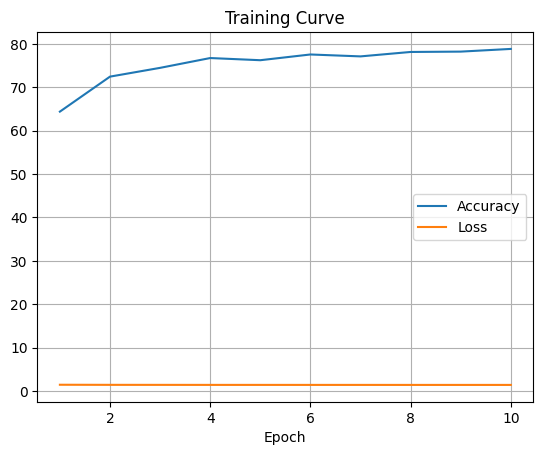

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), acc_list, label='Accuracy')
plt.plot(range(1, num_epochs+1), loss_list, label='Loss')
plt.legend()
plt.xlabel('Epoch')
plt.title('Training Curve')
plt.grid()
plt.show()

# Test

In [26]:
test_dataset = Omniglot(
    root=tmp_dir.name,
    background=False, # evaluation set
    transform=transform,
    download=True
)

100%|██████████| 6.46M/6.46M [00:00<00:00, 77.8MB/s]


In [27]:
print(type(test_dataset))
print(f"Total number of images: {len(test_dataset)}")
print(f"Sample item format: {test_dataset[0]}")
print(f"Label of first image: {test_dataset[0][1]}")

<class 'torchvision.datasets.omniglot.Omniglot'>
Total number of images: 13180
Sample item format: (tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0863, 0.1216, 0.0078, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.000

In [28]:
print(f"Total character classes: {len(test_dataset._characters)}")

Total character classes: 659


In [29]:
test_idx_to_char_name = {
    i: tuple(name.split('/'))  # split 'Alphabet/characterXX' into (Alphabet, character), hmm maybe shouldn't have done it
    for i, name in enumerate(test_dataset._characters)
}

In [30]:
test_class_to_indices = defaultdict(list)
for i, (_, label) in enumerate(test_dataset):
    test_class_to_indices[label].append(i)

In [31]:
from tqdm import tqdm

def evaluate_few_shot_model(
    model,
    test_dataset,
    test_class_to_indices,
    test_idx_to_char_name,
    loss_fn,
    num_ways=5,
    num_shots=1,
    num_queries=1,
    num_episodes=100,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    model.eval()
    model.to(device)

    total_loss = 0
    total_correct = 0
    total_queries = 0

    # Create test episode dataset and loader
    test_episode_dataset = FewShotEpisodeDataset(
        test_dataset,
        test_class_to_indices,
        test_idx_to_char_name,
        num_ways=num_ways,
        num_shots=num_shots,
        num_queries=num_queries,
        num_episodes=num_episodes
)


    test_loader = DataLoader(test_episode_dataset, batch_size=1, shuffle=False)

    print(f"\nEvaluating on {num_episodes} test episodes ({num_ways}-way {num_shots}-shot, {num_queries} queries/class)")
    test_bar = tqdm(test_loader, desc="Test episodes")

    with torch.no_grad():
        for episode in test_bar:
            support_images = episode['support_images'][0].to(device)
            support_labels = episode['support_labels'][0].to(device)
            query_images = episode['query_images'][0].to(device)
            query_labels = episode['query_labels'][0].to(device)

            logits = model(support_images, support_labels, query_images)
            preds = torch.argmax(logits, dim=1)
            correct = (preds == query_labels).sum().item()
            loss = loss_fn(logits, query_labels)

            total_loss += loss.item()
            total_correct += correct
            total_queries += query_labels.size(0)

            test_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Acc": f"{(correct / query_labels.size(0)) * 100:.2f}%"
            })

    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_queries * 100
    print(f" Test Summary → Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

    return accuracy, avg_loss



In [33]:
test_acc, test_loss = evaluate_few_shot_model(
    model=model,
    test_dataset=test_dataset,
    test_class_to_indices=test_class_to_indices,
    test_idx_to_char_name=test_idx_to_char_name,
    loss_fn=loss_fn,
    num_ways=5,
    num_shots=1,
    num_queries=1,
    num_episodes=600, # like in the papers
    device=device
)



Evaluating on 600 test episodes (5-way 1-shot, 1 queries/class)


Test episodes: 100%|██████████| 600/600 [00:05<00:00, 107.18it/s, Loss=1.5533, Acc=20.00%]

 Test Summary → Loss: 1.4885 | Accuracy: 69.13%
